# Decision Tree Implementation

In [1]:
import numpy as np
import pandas as pd

In [2]:
class DecisionTree:
    """Decision tree implementation, that works based on a simple implementation of the CART
       algorithm. Gini impurity is used as a measure to determine which feature of the data
       should be used to form the nodes of the decision tree. Categorical as well as continous
       data can be supplied to this class.
.

       Attributes:
         root: A string describing the data column used to split the data into branches.
         instance_counter: An integer counting how many data points reach the node.
         category_counter: An integer counting how many target categories the data contains.
         split_crit: A string specifying the split criterium used to split data into branches.
         children: List saving all branch nodes depening on a specific root node.
         max_dept: Specifies the maximal dept a decision tree is allowed to have.
         min_leaf_instances: Integer the minimal amount of data points needed to create branches. 
        
    """
    
    def __init__(self, max_dept=3, root=None, split_crit=None, min_leaf_instances=1):
        self.root = root
        self.instance_counter = None
        self.category_counter = None
        self.split_crit = split_crit
        self.children = []
        self.max_dept = max_dept
        self.min_leaf_instances = min_leaf_instances
      
    
    @staticmethod
    def gini_impurity(df, column, target):
        """Calculates gini impurity if df is split on column, returns result and modified df"""
        
        # Finds out if column contains continuous data:
        continuous = False
        if df.dtypes[column] == float:
            continuous = True
        
        if not continuous:
            # Used to safe the gini impurity of the unique categories before total sum is calculated
            gini_sums = []
            
            # Finds all the unique categories in a column
            for unique_cat in np.unique(df[column]):
                gini = 1
                
                # Determines the Gini impurity of all unique categories
                values = df.loc[df[column] == unique_cat][target].value_counts()
                for value in values:
                    gini -= (value / sum(values)) ** 2
                gini_sums.append((gini, sum(values)))
            
            # Returns the gini impurity and unmodified df 
            result = sum([gini_value * p / len(df) for (gini_value, p) in gini_sums])
            return result, df
            
        if continuous:
            # Saves the best gini impurity value as well as modified df
            best_gini = 2
            best_df = None
            
            # Finds 5 possible threshholds based on which to split the dataset
            for thresh in np.linspace(np.min(df[column]),
                                          np.max(df[column]), num=5):
                # Used to safe the gini impurity of the unique categories before total sum calculation
                thresh_sums = []
                
                # Modifies column of initial df to be categorical
                idx = df[df[column] >= thresh].index
                df_copy = df.copy()
                df_copy[column] = '<' + str(thresh)
                df_copy.loc[idx, column] = '>=' + str(thresh)
                
                # Finds all the unique categories in a column of modified df
                for unique_val in np.unique(df_copy[column]):
                    gini = 1
                    values = df.loc[df_copy[column] == unique_val][target].value_counts()
                    for value in values:
                        gini -= (value / sum(values)) ** 2
                    thresh_sums.append((gini, sum(values)))
                thresh_result = sum([gini_value * p / len(df) for (gini_value, p) in thresh_sums])
                
                # Safes gini impurity and modified df, if threshhold overperforms
                if thresh_result < best_gini:
                    best_gini = thresh_result
                    best_df = df_copy
                    
            # Returns the gini impurity and modified df 
            return best_gini, best_df
    
    
    def find_root(self, df, target):
        """Finds the best root node for a df, returns root and modified df"""
        
        columns = [column for column in df.columns if column != target]
        
        # Saves column best suited as root node, gini impurity and modified df
        min_gini = 2
        root = columns[0]
        root_df = 0
        
        # Iterates through all columns, calculates gini impurity
        for column in columns:
            column_gini, new_df = self.gini_impurity(df, column, target)
            if column_gini < min_gini:
                min_gini = column_gini
                root = column
                root_df = new_df 
        
        if column_gini == 2:
            raise ValueError("Final Gini impurity should never be 2!")
            
        # Split does not improve performance of the tree, no root will be returned
        elif min_gini == 1:
            return None
        
        # Returns the root node as well as modified df
        return root, root_df
    
    def divide_df(self, df, target):
        """Divides the df based on the root node"""
        
        # Saves all splits of the initial df
        divided_df = []
        
        # Returns no splits of the df if there is only one column left or no variation of target 
        if len(np.unique(df[target])) == 1 or len(df.columns) <= 2:
            return tables
        
        # Iterates through the categories of the root node to split the df
        for unique_class in np.unique(df[self.root]):
            view = df[df[self.root] == unique_class]
            view = view.drop(self.root, axis=1)
            divided_df.append((view, unique_class))
        return divided_df
    
    
    def train(self, df, target):
        """Trains the decision tree based on the training data provided"""
        
        # Finds the root node of decision treeif not available
        if self.root == None:
            self.root, new_df = self.find_root(df, target)
            df = new_df

        self.instance_counter = str(len(df))
        self.category_counter = df[target].value_counts()
        
        # Stops training, if one stopping criteria is reached
        if len(np.unique(df[target])) <= self.min_leaf_instances or self.max_dept == 0:
            return
        
        # Devides df based on root node, iterates over branches and recursevly continues training
        divided_df = self.divide_df(df, target)
        for (view, unique_class) in divided_df:
            child = DecisionTree(root=None, split_crit=unique_class, max_dept=self.max_dept-1)
            self.children.append(child)
            child.train(view, target)      
        return "Training finished!"
    
    
    def predict(self, value):
        """Predicts and returns the target class of a value"""
        
        branch_value = value[self.root]
        
        # Outputs the most likely target class in case no child nodes were found
        if len(self.children) == 0:
            win_ind = 0
            win_count = 0
            for i, cat_count in enumerate(self.category_counter):
                if cat_count > win_count:
                    win_ind = i
                    win_count = cat_count
            return self.category_counter.index[win_ind]
        
        else:
            for child in self.children:
                # Used in case the column data is not continuous
                if child.split_crit == branch_value:
                    return child.predict(value)
                # Used in case the column data is continuous
                elif child.split_crit[0] == "<":
                    if branch_value < float(child.split_crit[1:]):
                        return child.predict(value)
                elif child.split_crit[:2] == ">=":
                    if branch_value >= float(child.split_crit[2:]):
                        return child.predict(value)
            
            # Outputs the most likely target class in case no child nodes were found        
            win_ind = 0
            win_count = 0
            for i, cat_count in enumerate(self.category_counter):
                if cat_count > win_count:
                    win_ind = i
                    win_count = cat_count
            return self.category_counter.index[win_ind]
            
            
    def __str__(self, level=0):
        """Outputs the decision tree nodes/branches"""
        
        if self.split_crit == None:
            tree = "\t" * level + "Instances: " + self.instance_counter + "\n"
            if len(self.children) != 0:
                tree += "+" + "\t" * level  + "Root: " + str(self.root) + "\n" 

        else:
            tree = "\t" * level + "Split Criterion: " + str(self.split_crit) + "\n"
            tree += "\t" * level + "  " + "Instances: " + self.instance_counter + "\n"
            for i, instances in enumerate(self.category_counter):
                tree += "\t" * level + "  " + f"Class {self.category_counter.index[i]}: {instances}" + "\n"
            if len(self.children) != 0:
                tree += "  \t" * level + "    " + "Root: " + str(self.root) + "\n" 
        
        for child in self.children:
            tree += child.__str__(level+1)
        return tree


# Databases

In [3]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import metrics

## Weather Dataset

In [4]:
np.random.seed(43)

In [6]:
# Imports the weather dataset into pandas df
weather_df = pd.read_csv("weather-data.csv")
del weather_df['Day']
weather_df['Decision'].replace(['No', 'Yes'], [0, 1], inplace=True)

# Shuffles the weather dataset
weather_df = weather_df.sample(frac = 1)

# Splits the weather dataset into training and testing
split = int(len(weather_df) * 0.7)
weather_train = weather_df[:split]
weather_test = weather_df[split:]

In [190]:
print("The weather dataset can be seen below:\n")
print(weather_df)
print("\nPart of the dataset used for training:\n")
print(weather_train)
print("\nPart of the dataset used for testing:\n")
print(weather_test)

The weather dataset can be seen below:

     Outlook Temperature Humidity    Wind  Decision
9   Rainfall        Mild   Normal    Weak         1
7      Sunny        Mild     High    Weak         0
10     Sunny        Mild   Normal  Strong         1
13  Rainfall        Mild     High  Strong         0
2   Overcast         Hot     High    Weak         1
6   Overcast        Cool   Normal  Strong         1
8      Sunny        Cool   Normal    Weak         1
11  Overcast        Mild     High  Strong         1
3   Rainfall        Mild     High    Weak         1
12  Overcast         Hot   Normal    Weak         1
5   Rainfall        Cool   Normal  Strong         0
1      Sunny         Hot     High  Strong         0
0      Sunny         Hot     High    Weak         0
4   Rainfall        Cool   Normal    Weak         1

Part of the dataset used for training:

     Outlook Temperature Humidity    Wind  Decision
9   Rainfall        Mild   Normal    Weak         1
7      Sunny        Mild     High  

Visualization of the weather dataset:


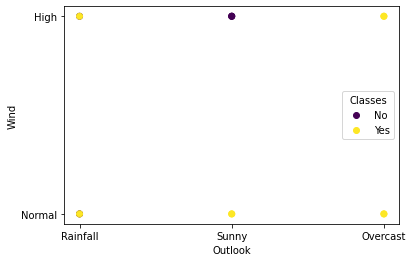

In [191]:
print("Visualization of the weather dataset:")
fig, ax = plt.subplots()
scatter = ax.scatter(weather_df["Outlook"], weather_df["Humidity"], c=weather_df['Decision'])
ax.set(xlabel="Outlook", ylabel="Wind")
legend = ax.legend(scatter.legend_elements()[0], ['No', 'Yes'], title="Classes")

In [193]:
print("Decision tree structure based on the training data:\n")
my_decision_tree = DecisionTree()
my_decision_tree.train(weather_train, "Decision")
print(my_decision_tree)

prediction = weather_test.apply(my_decision_tree.predict, axis=1)
weather_test.loc[:, 'Predicted'] = prediction

Decision tree structure based on the training data:

Instances: 9
+Root: Humidity
	Split Criterion: High
	  Instances: 5
	  Class 1: 3
	  Class 0: 2
  	    Root: Outlook
		Split Criterion: Overcast
		  Instances: 2
		  Class 1: 2
		Split Criterion: Rainfall
		  Instances: 2
		  Class 0: 1
		  Class 1: 1
  	  	    Root: Wind
			Split Criterion: Strong
			  Instances: 1
			  Class 0: 1
			Split Criterion: Weak
			  Instances: 1
			  Class 1: 1
		Split Criterion: Sunny
		  Instances: 1
		  Class 0: 1
	Split Criterion: Normal
	  Instances: 4
	  Class 1: 4



In [194]:
print("The decision tree reached an accuracy of 80%\n")
print("Confusion matrix: \n")
confusion_matrix = metrics.confusion_matrix(weather_test['Decision'], weather_test['Predicted'])
print(confusion_matrix)
print("\nClassification report:\n")
print(metrics.classification_report(weather_test['Decision'], weather_test['Predicted']))

The decision tree reached an accuracy of 80%

Confusion matrix: 

[[2 1]
 [0 2]]

Classification report:

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.67      1.00      0.80         2

    accuracy                           0.80         5
   macro avg       0.83      0.83      0.80         5
weighted avg       0.87      0.80      0.80         5



In [195]:
# Deletes predictions
del weather_test['Predicted']

# Inserts NaN columns
weather_test.loc[1, 'Humidity'] = np.nan
weather_test.loc[1, 'Temperature'] = np.nan

print("The decision tree works, even if some columns are equal to Nan!\n")
print("Example datapoint:\n")
print(weather_test.loc[1])
print("\nPrediction:\n")
print(my_decision_tree.predict(weather_test.loc[1]))

The decision tree works, even if some columns are equal to Nan!

Example datapoint:

Outlook         Sunny
Temperature       NaN
Humidity          NaN
Wind           Strong
Decision            0
Name: 1, dtype: object

Prediction:

1


## Iris Dataset

In [196]:
iris = datasets.load_iris()

In [197]:
iris_df = pd.DataFrame(iris['data'],
                       columns=['sepal length (cm)',
                                'sepal width (cm)',
                                'petal length (cm)',
                                'petal width (cm)'])
iris_df['target'] = iris['target']

# Shuffles the iris dataset
iris_df = iris_df.sample(frac = 1)

# Splits the iris dataset into training and testing
split = int(len(iris_df) * 0.8)
iris_train = iris_df[:split]
iris_test = iris_df[split:]

In [198]:
print("The iris dataset can be seen below:\n")
print(iris_df)
print("\nPart of the dataset used for training:\n")
print(iris_train)
print("\nPart of the dataset used for testing:\n")
print(iris_test)

The iris dataset can be seen below:

     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
19                 5.1               3.8                1.5               0.3   
71                 6.1               2.8                4.0               1.3   
39                 5.1               3.4                1.5               0.2   
108                6.7               2.5                5.8               1.8   
0                  5.1               3.5                1.4               0.2   
..                 ...               ...                ...               ...   
89                 5.5               2.5                4.0               1.3   
123                6.3               2.7                4.9               1.8   
127                6.1               3.0                4.9               1.8   
35                 5.0               3.2                1.2               0.2   
64                 5.6               2.9                3.6             

Visualization of the iris dataset:


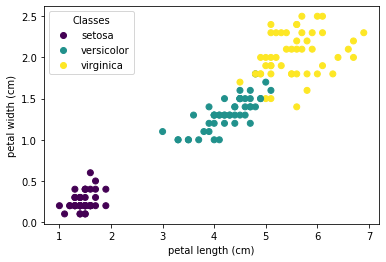

In [199]:
print("Visualization of the iris dataset:")
fig, ax = plt.subplots()
scatter = ax.scatter(iris_df["petal length (cm)"], iris_df["petal width (cm)"], c=iris_df['target'])
ax.set(xlabel="petal length (cm)", ylabel="petal width (cm)")
legend = ax.legend(scatter.legend_elements()[0], iris['target_names'], title="Classes")

In [201]:
print("Decision tree structure based on the training data (max_dept=3, min_leaf_instances=1):\n")
my_decision_tree = DecisionTree(max_dept=3, min_leaf_instances=1)
my_decision_tree.train(iris_train, "target")
print(my_decision_tree)
iris_test.loc[:, 'Predicted'] = iris_test.apply(my_decision_tree.predict, axis=1) 

Decision tree structure based on the training data (max_dept=3, min_leaf_instances=1):

Instances: 120
+Root: petal length (cm)
	Split Criterion: <2.475
	  Instances: 41
	  Class 0: 41
	Split Criterion: >=2.475
	  Instances: 79
	  Class 1: 42
	  Class 2: 37
  	    Root: petal width (cm)
		Split Criterion: <1.75
		  Instances: 45
		  Class 1: 41
		  Class 2: 4
  	  	    Root: sepal length (cm)
			Split Criterion: <7.2
			  Instances: 44
			  Class 1: 41
			  Class 2: 3
			Split Criterion: >=7.2
			  Instances: 1
			  Class 2: 1
		Split Criterion: >=1.75
		  Instances: 34
		  Class 2: 33
		  Class 1: 1
  	  	    Root: sepal length (cm)
			Split Criterion: <6.175
			  Instances: 8
			  Class 2: 7
			  Class 1: 1
			Split Criterion: >=6.175
			  Instances: 26
			  Class 2: 26



In [203]:
print("The decision tree reached an accuracy of 97%\n")
print("Confusion matrix: \n")
confusion_matrix = metrics.confusion_matrix(iris_test['target'], iris_test['Predicted'])
print(confusion_matrix)
print("\nClassification report:\n")
print(metrics.classification_report(iris_test['target'], iris_test['Predicted']))

The decision tree reached an accuracy of 97%

Confusion matrix: 

[[ 9  0  0]
 [ 0  8  0]
 [ 0  1 12]]

Classification report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       0.89      1.00      0.94         8
           2       1.00      0.92      0.96        13

    accuracy                           0.97        30
   macro avg       0.96      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



In [209]:
# Deletes predictions
del iris_test['Predicted']

# Inserts NaN columns
iris_test.loc[107, 'sepal length (cm)'] = np.nan
iris_test.loc[107, 'sepal width (cm)'] = np.nan

print("The decision tree works, even if some columns are equal to Nan!\n")
print("Example datapoint:\n")
print(iris_test.loc[107])
print("\nPrediction:\n")
print(my_decision_tree.predict(iris_test.loc[1]))

The decision tree works, even if some columns are equal to Nan!

Example datapoint:

sepal length (cm)    NaN
sepal width (cm)     NaN
petal length (cm)    6.3
petal width (cm)     1.8
target               2.0
Name: 107, dtype: float64

Prediction:

1
